In [1]:
import yfinance as yf
import numpy as np
from pathlib import Path


def load_data(ticker): 
    
    def get_timeseries(ticker):
        yfin = yf.Ticker(ticker)
        data = yfin.history(period="max")
        return data

    def preprocess_data(data):
        data = data[['Close']]
        data.reset_index(level=0, inplace=True)
        data.rename({'Date': 'ds', 'Close': 'y'}, axis='columns', inplace=True)
        print(data.head())
        data['ds'] = data['ds'].dt.tz_localize(None)
        return data
    
    filePath = ticker + ".npy"

    my_file = Path(filePath)
    if not my_file.is_file():
        x = get_timeseries(ticker)
        x = preprocess_data(x)

        x = x["y"].to_numpy()
        np.save(ticker, x)
    else:
        x = np.load(filePath)
    
    return x
    
x = load_data('MSFT')

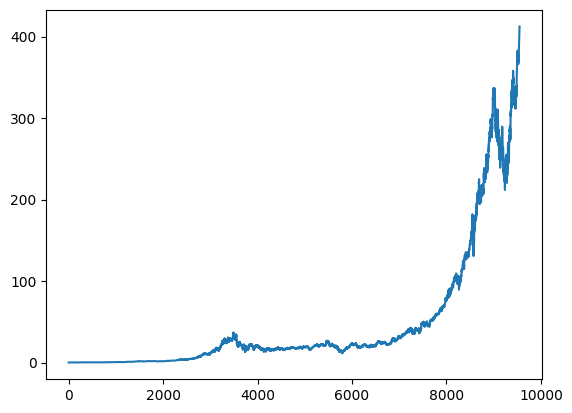

In [3]:
import matplotlib.pyplot as plt 

plt.plot(x)
plt.show()

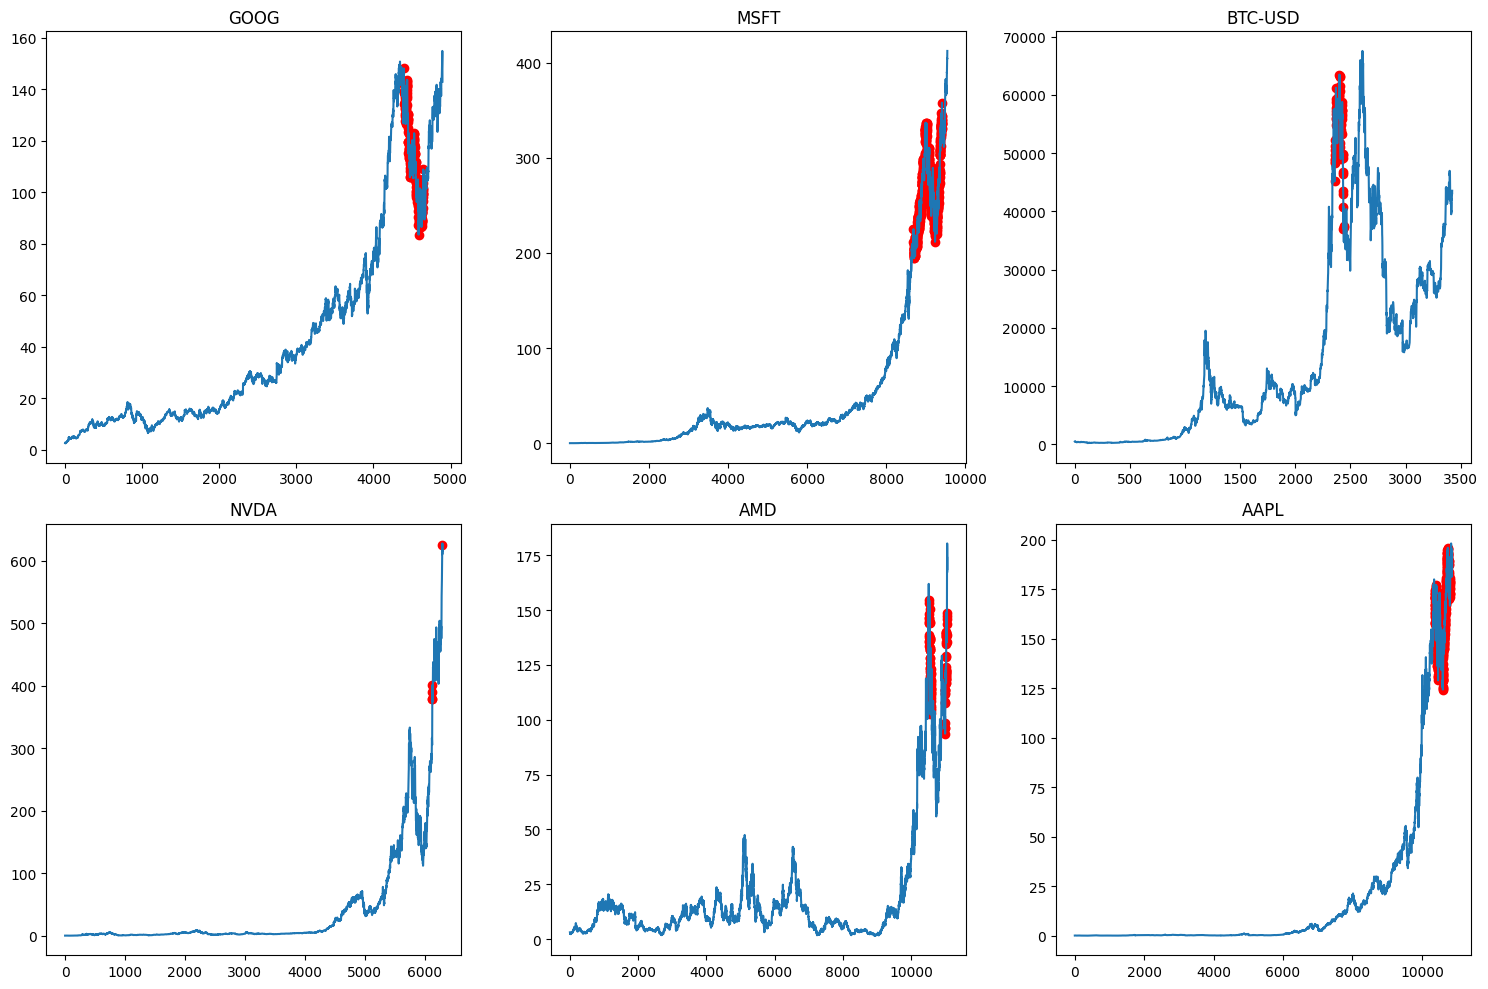

In [71]:

def localOutlier(data, p, c, threshold):
    N = len(data)
    p = min(p, N // 2)
    p = int(0.001 * N)
    X = np.fft.rfft(data)
    keptComponents = np.argsort(-np.abs(X))[: p]
    
    for i in keptComponents:
        X[i] = 0
    
    y = np.fft.irfft(X, len(data))
    
    diffs = np.abs(data - y)
    meanDiffs = np.mean(diffs)
    
    S = []
    Sidx = []
    for (idx, d) in enumerate(diffs):
        if d > meanDiffs:
            left = max(idx - c, 0)
            right = min(idx + c, N)
            
            neighbours = np.concatenate([data[left : idx], data[idx + 1 : right]])
            S.append(data[idx] - np.mean(neighbours))
            Sidx.append(idx)

    S = np.array(S)
    Sidx = np.array(Sidx)
    
    meanS = np.mean(S)
    stdS = np.std(S)
    z = (S - meanS) / stdS
    zAbs = np.abs(z)
    
    threshold = np.quantile(zAbs, 0.99)
    zValues = z[zAbs > threshold]
    anomalyIndices = Sidx[zAbs > threshold]
    
    # plt.plot(data, color='blue', label='original data')
    # plt.plot(y, color='red', label='IFFT data')
    # plt.scatter(Sidx, S, color='green')
    # plt.legend()
    # plt.show()
    
    return (zValues, anomalyIndices)


def regionOutlier(zValues, anomalyIndices, max_local, max_region):
    outlier_regions = []
    count = len(zValues)
    
    i = 0
    while i < count:
        sign = np.sign(zValues[i])
        i += 1
        m = 0
        
        while m < max_local and i < count:
            if np.sign(zValues[i]) != sign:
                start_marker = i
                i += 1
                n = 0
                
                while n < max_region and i < count:
                    if (
                        np.sign(zValues[i]) == np.sign(zValues[start_marker]) and
                        i - start_marker <= max_local
                    ):
                        end_marker = i
                        outlier_regions.append((anomalyIndices[start_marker], anomalyIndices[end_marker]))
                        break
                    else:
                        i += 1
                        n += 1
                
                else:
                    i = start_marker + 1
                
            else:
                i += 1
                m += 1
    
    return outlier_regions

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
i = 0
for t in ['GOOG', 'MSFT', 'BTC-USD', 'NVDA', 'AMD', 'AAPL']:
    row = i // 3
    col = i % 3
    x = load_data(t)
    magnitudeParams = 5
    numberOfNeighbours = 10
    zValues, anomalyIndices = localOutlier(x, magnitudeParams, numberOfNeighbours, 0.1)

    max_local = 5
    max_region = 6

    outlier_regions = regionOutlier(zValues, anomalyIndices, max_local, max_region)

    axs[row][col].plot(x)

    for (l, r) in outlier_regions:
        axs[row][col].scatter(range(l, r, 1), x[l: r], color='red')
        
    axs[row][col].set_title(t)
    i += 1

fig.tight_layout()
fig.savefig("fft_results.pdf")
fig.show()